In [38]:
!nvidia-smi

Tue Feb 14 17:33:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    28W /  70W |   2936MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# ***DATA GATHERING And PREPROCESSING***

In [17]:
import os
import numpy as np
import sys
import random

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

os.environ['KAGGLE_USERNAME'] = 'username'
os.environ['KAGGLE_KEY'] = 'key'

In [2]:
!kaggle competitions download -c data-science-bowl-2018

 98% 352M/358M [00:03<00:00, 149MB/s]
100% 358M/358M [00:03<00:00, 108MB/s]


In [9]:
!mkdir dataset

In [5]:
!unzip /content/data-science-bowl-2018.zip -d /content/datasets

Archive:  /content/data-science-bowl-2018.zip
  inflating: /content/datasets/stage1_sample_submission.csv.zip  
  inflating: /content/datasets/stage1_solution.csv.zip  
  inflating: /content/datasets/stage1_test.zip  
  inflating: /content/datasets/stage1_train.zip  
  inflating: /content/datasets/stage1_train_labels.csv.zip  
  inflating: /content/datasets/stage2_sample_submission_final.csv.zip  
  inflating: /content/datasets/stage2_test_final.zip  


In [10]:
from zipfile import ZipFile
req_files = ["stage1_train","stage1_test","stage1_train_labels.csv"]
for file_name in req_files:
  with ZipFile(f"datasets/{file_name}.zip", 'r') as zip:
    zip.extractall(path = f"dataset/{file_name}")
print("All done...")

All done...


In [11]:
TRAIN_PATH = 'dataset/stage1_train/'
TEST_PATH = 'dataset/stage1_test/'

In [12]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [15]:
WIDTH = 128
HEIGHT = 128
CHANNELS = 3

In [ ]:
X_train = np.zeros((len(train_ids), HEIGHT, WIDTH, CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), HEIGHT, WIDTH, 1), dtype = np.bool)

In [18]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
  path = TRAIN_PATH + id_
  img = imread(path + '/images/' + id_ + '.png')[:,:,:CHANNELS]
  img = resize(img, (HEIGHT, WIDTH), mode = 'constant', preserve_range = True)
  X_train[n] = img
  mask = np.zeros((HEIGHT, WIDTH, 1), dtype = np.bool)
  for mask_file in next(os.walk(path + '/masks/'))[2]:
    mask_ = imread(path + '/masks/' + mask_file)
    mask_ = np.expand_dims(resize(mask_, (HEIGHT, WIDTH), mode = 'constant', preserve_range = True), axis = -1)
    mask = np.maximum(mask, mask_)
  Y_train[n] = mask

Resizing training images and masks


  0%|          | 0/670 [00:00<?, ?it/s]<ipython-input-18-68fe7e9625b3>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((HEIGHT, WIDTH, 1), dtype = np.bool)
100%|██████████| 670/670 [06:36<00:00,  1.69it/s]


In [20]:
X_test = np.zeros((len(test_ids), HEIGHT, WIDTH, CHANNELS), dtype = np.uint8)
sizes_test = []
print('Resizing test images and masks')
for n, id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
  path = TEST_PATH + id_
  img = imread(path + '/images/' + id_ + '.png')[:,:,:CHANNELS]
  sizes_test.append([img.shape[0], img.shape[1]])
  img = resize(img, (HEIGHT, WIDTH), mode = 'constant', preserve_range = True)
  X_test[n] = img
print('Done..')

Resizing test images and masks


100%|██████████| 65/65 [00:01<00:00, 40.30it/s]

Done..


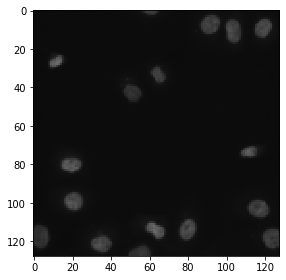

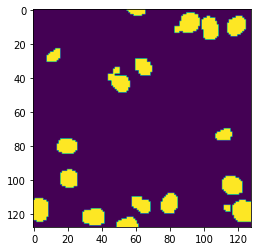

In [28]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
plt.imshow(np.squeeze(Y_train[image_x][:,:,0]))

# ***Model Development***
<img src = "https://www.researchgate.net/profile/Thanh_Nguyen68/publication/317493482/figure/download/fig6/AS:639677962915851@1529522519694/U-net-Convolutional-Neural-Network-model-The-U-net-model-contains-two-parts.png"/>

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.utils import plot_model

In [30]:
inputs = Input((WIDTH, HEIGHT, CHANNELS))

In [31]:
scale = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [32]:
# Contraction Path

c_1 = Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(scale)
c_1 = Dropout(0.1)(c_1)
c_1 = Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c_1)
p_1 = MaxPooling2D((2, 2))(c_1)

c_2 = Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p_1)
c_2 = Dropout(0.1)(c_2)
c_2 = Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c_2)
p_2 = MaxPooling2D((2, 2))(c_2)

c_3 = Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p_2)
c_3 = Dropout(0.2)(c_3)
c_3 = Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c_3)
p_3 = MaxPooling2D((2, 2))(c_3)

c_4 = Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p_3)
c_4 = Dropout(0.2)(c_4)
c_4 = Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c_4)
p_4 = MaxPooling2D((2, 2))(c_4)

c_5 = Conv2D(256, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p_4)
c_5 = Dropout(0.3)(c_5)
c_5 = Conv2D(256, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c_5)

In [33]:
# Expansive Path

u_6 = Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(c_5)
u_6 = concatenate([u_6, c_4])
c_6 = Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u_6)
c_6 = Dropout(0.2)(c_6)
c_6 = Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c_6)

u_7 = Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(c_6)
u_7 = concatenate([u_7, c_3])
c_7 = Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u_7)
c_7 = Dropout(0.2)(c_7)
c_7 = Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c_7)

u_8 = Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(c_7)
u_8 = concatenate([u_8, c_2])
c_8 = Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u_8)
c_8 = Dropout(0.1)(c_8)
c_8 = Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c_8)

u_9 = Conv2DTranspose(16, (2, 2), strides = (2, 2), padding = 'same')(c_8)
u_9 = concatenate([u_9, c_1], axis = 3)
c_9 = Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u_9)
c_9 = Dropout(0.1)(c_9)
c_9 = Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c_9)

outputs = Conv2D(1, (1, 1), activation = 'sigmoid')(c_9)

In [34]:
model = Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [36]:
# Model checkpoint

checkPoint = tf.keras.callbacks.ModelCheckpoint('model_of_nuclei.h5', verbose = 1, save_best_only = True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs')
]

In [37]:
results = model.fit(X_train, Y_train, validation_split = 0.1, batch_size = 16, epochs = 25, callbacks = callbacks)

Epoch 1/25
38/38 [==============================] - 21s 89ms/step - loss: 0.6532 - accuracy: 0.7691 - val_loss: 0.6247 - val_accuracy: 0.7502
Epoch 2/25
38/38 [==============================] - 2s 45ms/step - loss: 0.4871 - accuracy: 0.8047 - val_loss: 0.4401 - val_accuracy: 0.7502
Epoch 3/25
38/38 [==============================] - 2s 45ms/step - loss: 0.3067 - accuracy: 0.8537 - val_loss: 0.2774 - val_accuracy: 0.8597
Epoch 4/25
38/38 [==============================] - 2s 45ms/step - loss: 0.2009 - accuracy: 0.9223 - val_loss: 0.2102 - val_accuracy: 0.9180
Epoch 5/25
38/38 [==============================] - 2s 46ms/step - loss: 0.1594 - accuracy: 0.9392 - val_loss: 0.1595 - val_accuracy: 0.9351
Epoch 6/25
38/38 [==============================] - 2s 47ms/step - loss: 0.1290 - accuracy: 0.9512 - val_loss: 0.1429 - val_accuracy: 0.9380
Epoch 7/25
38/38 [==============================] - 2s 45ms/step - loss: 0.1196 - accuracy: 0.9542 - val_loss: 0.1271 - val_accuracy: 0.9468
Epoch 8/25
3

In [39]:
pred_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
pred_vals = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
pred_test = model.predict(X_test, verbose = 1)

3/3 [==============================] - 0s 140ms/step


In [42]:
pred_train_t = (pred_train > 0.5).astype(np.uint8)
pred_val_t = (pred_vals > 0.5).astype(np.uint8)
pred_test_t = (pred_test > 0.5).astype(np.uint8)

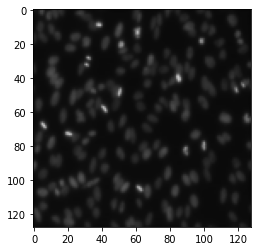

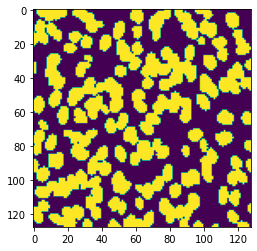

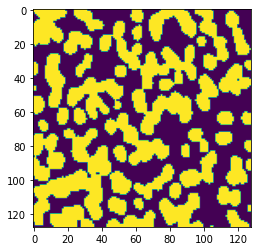

In [45]:
idx = random.randint(0, len(pred_train))
plt.imshow(X_train[idx])
plt.show()
plt.imshow(np.squeeze(Y_train[idx]))
plt.show()
plt.imshow(np.squeeze(pred_train_t[idx]))

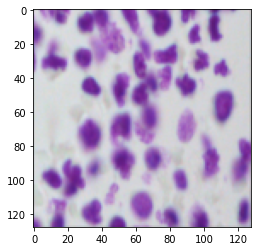

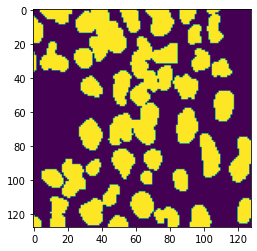

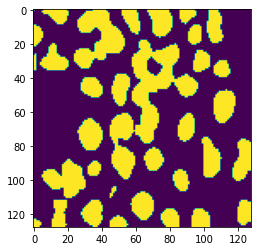

In [53]:
idx = random.randint(0, len(pred_vals))
plt.imshow(X_train[int(X_train.shape[0]*0.9):][idx])
plt.show()
plt.imshow(np.squeeze((Y_train[int(Y_train.shape[0]*0.9):][idx])))
plt.show()
plt.imshow(np.squeeze(pred_val_t[idx]))